# **PROBLEMA DE NEGOCIO**


---

### Una tienda online de moda, con presencia en todo Brasil, necesita impulsar su rendimiento utilizando sus datos de manera estratégica. Como científico de datos, has sido convocado para analizar estos datos y ofrecer insights que guíen sus decisiones y respondan a las siguientes preguntas clave:

### **Preguntas**

1. ¿Cual es el Top 5 productos más vendidos históricamente?

2. ¿Cual es la evolución histórica de las ingresos netos?

3. ¿Cuáles son los ingresos netos por vendedor por año?

4. ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?

5. ¿Existe otro insight que puedas proporcionar?

# **1. Configuración del Ambiente**


---

**Se importan las librerias necesarias para el análisis**
--

In [20]:
!pip install geobr
import geobr
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
from PIL import Image
from io import BytesIO
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, Float, String, DateTime, inspect, text
global df_items_pedidos, df_pedidos, df_productos, df_vendedores, database

# **2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---


## **2.1 Cargando las bases de datos**

Creamos una función para cargar todas las bases de datos necesarias para el análisis
--

In [21]:
def carga_datos():
  global df_items_pedidos, df_pedidos, df_productos, df_vendedores, database
  df_items_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/itens_pedidos.csv')
  df_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/pedidos.csv')
  df_productos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/productos.csv')
  df_vendedores = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/vendedores.csv')

## **2.2 Tratamiento de datos**

**Se visualiza la información general de cada dataframe previa al tratamiento**
--

In [22]:
carga_datos()
print(df_items_pedidos.info())
print('-------------')
print(df_pedidos.info())
print('-------------')
print(df_productos.info())
print('-------------')
print(df_vendedores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pedido_id     24527 non-null  int64 
 1   producto_id   24527 non-null  int64 
 2   vendedor_id   24527 non-null  int64 
 3   fecha_compra  24527 non-null  object
 

**Creamos una función para realizar preprocesamiento a todos los dataframes.**
--
*Se eliminan duplicados, se transforman datos numéricos a (int), textos a (str) y fechas a (datetime)*


In [23]:
#Preprocesamiento
def preprocesamiento(df_items_pedidos, df_pedidos, df_productos, df_vendedores):
    # Crear copias de los dataframes originales
    items_pedidos_copy = df_items_pedidos.copy()
    pedidos_copy = df_pedidos.copy()
    productos_copy = df_productos.copy()
    vendedores_copy = df_vendedores.copy()

    dataframes = [items_pedidos_copy, pedidos_copy, productos_copy, vendedores_copy]
    pedidos_copy['fecha_compra'] = pd.to_datetime(pedidos_copy['fecha_compra'])

    for df in dataframes:
        # Eliminar registros con valores nulos en las columnas clave
        df.dropna(subset=df.columns[df.columns.str.endswith('_id')], inplace=True)
        # Eliminar registros duplicados
        df.drop_duplicates(inplace=True)
        # Asegurar tipos de datos correctos
        for column in df.columns:
                if df[column].dtype == 'object':
                    df[column] = df[column].astype(str)
                elif df[column].dtype == 'float64':
                    df[column] = df[column].astype(float)
                elif df[column].dtype == 'int64':
                    df[column] = df[column].astype(int)
    return items_pedidos_copy, pedidos_copy, productos_copy, vendedores_copy


##Aplicar función de preprocesamiento y renombrando dataframes

In [24]:
items_pedidos_procesados, pedidos_procesados, productos_procesados, vendedores_procesados = preprocesamiento(df_items_pedidos, df_pedidos, df_productos, df_vendedores)

**Creamos una función para verificación.**
--
*Esta permite identificar inconsistencias en los datos como valores nulos, duplicados, caracteres especiales para columnas de texto y valores NaN en todo el data set.*


In [25]:
def verificacion(dataframe):
  global df_items_pedidos_procesados, df_pedidos_procesados, df_productos_procesados, df_vendedores_procesados, database
    # Verificar valores nulos
  print("Valores nulos por columna:")
  print(dataframe.isnull().sum())
  print("\n")

  # Verificar duplicados
  duplicados = dataframe.duplicated()
  df_duplicados = dataframe[duplicados]
  if not df_duplicados.empty:
      print("Filas duplicadas:")
      print(df_duplicados)
      print("\n")

  # Contar valores únicos en cada columna
  print("Conteo de valores únicos por columna:")
  for columna in dataframe.columns:
      print(f"Columna '{columna}': {dataframe[columna].nunique()} valores únicos")
      print(f"Valores únicos en '{columna}':")
      #print(dataframe[columna].unique())
      print("\n")

  # Verificar tipos de datos por columna
  print("\nTipos de datos por columna:")
  for columna in dataframe.columns:
      print(f"Columna '{columna}': {dataframe[columna].dtype}")

  # Verificar tipos de datos y buscar inconsistencias
  for columna in dataframe.select_dtypes(include=['object', 'string']).columns:
      print(f"\nVerificando inconsistencias en la columna '{columna}':")
      inconsistencias = dataframe[dataframe[columna].apply(lambda x: not all(ord(c) < 128 for c in str(x)))]
      if not inconsistencias.empty:
          print(inconsistencias)
          print("\n")

  #Verificar Nan en todo el dataset
  print("Valores NaN por columna:")
  df_nan = dataframe[dataframe.isna().any(axis=1)]
  print(df_nan.head())
  print("\n")

**Aplicando la función verificación a cada dataframe para realizar limpieza**
--

-Productos_procesados

In [26]:
verificacion(productos_procesados)

Valores nulos por columna:
producto_id    0
producto       0
precio         0
marca          0
sku            2
condicion      0
dtype: int64


Conteo de valores únicos por columna:
Columna 'producto_id': 207 valores únicos
Valores únicos en 'producto_id':


Columna 'producto': 202 valores únicos
Valores únicos en 'producto':


Columna 'precio': 85 valores únicos
Valores únicos en 'precio':


Columna 'marca': 117 valores únicos
Valores únicos en 'marca':


Columna 'sku': 205 valores únicos
Valores únicos en 'sku':


Columna 'condicion': 3 valores únicos
Valores únicos en 'condicion':



Tipos de datos por columna:
Columna 'producto_id': int64
Columna 'producto': object
Columna 'precio': int64
Columna 'marca': object
Columna 'sku': float64
Columna 'condicion': object

Verificando inconsistencias en la columna 'producto':

Verificando inconsistencias en la columna 'marca':
     producto_id                    producto  precio              marca  \
30         16634     Vestido Estampa Bord

In [27]:
productos_procesados[productos_procesados["precio"] == 210]

,producto_id,producto,precio,marca,sku,condicion
22,23575,Camiseta Animal Print,210,284,283163.0,Usado
72,70673,Shorts Listras Bordados,210,American Eagle,126190.0,Usado
86,45878,Vestido Preto Bolso,210,Zara,114614.0,Usado
149,50330,Camisa Jeans Azul,210,Zara,250096.0,Usado
152,5567,Vestido Medio Florl,210,Amaro,525428.0,Usado
164,65473,Oculos Acetato Branco,210,Mango,944049.0,Usado
183,32126,Saia Midi Cinto,210,Limone By Jade Seba,302628.0,Nuevo sin etiqueta
206,32926,nan,210,Limone By Jade Seba,NaN,Nuevo sin etiqueta


In [28]:
productos_procesados[productos_procesados["marca"] == 'Limone By Jade Seba']

,producto_id,producto,precio,marca,sku,condicion
183,32126,Saia Midi Cinto,210,Limone By Jade Seba,302628.0,Nuevo sin etiqueta
206,32926,nan,210,Limone By Jade Seba,NaN,Nuevo sin etiqueta


In [29]:
productos_procesados[productos_procesados["precio"] ==260]

,producto_id,producto,precio,marca,sku,condicion
199,9809,Cropped Courino Texturas,260,H&m,312006.0,Usado
204,41518,Calca Jeans Basica,260,Banana Republic,255410.0,Nuevo con etiqueta
205,41598,nan,260,Banana Republic,NaN,Nuevo con etiqueta


In [30]:
productos_procesados[productos_procesados["marca"] == 'Banana Republic']

,producto_id,producto,precio,marca,sku,condicion
6,21429,Casaco Preto Botoes,390,Banana Republic,321380.0,Usado
10,46573,Saia Amarela Faixa,350,Banana Republic,291820.0,Usado
18,10795,Blusinha Guipir Black,300,Banana Republic,224603.0,Usado
65,59784,Calca Ziper Preto,390,Banana Republic,314958.0,Usado
204,41518,Calca Jeans Basica,260,Banana Republic,255410.0,Nuevo con etiqueta
205,41598,nan,260,Banana Republic,NaN,Nuevo con etiqueta


### Después de revisar la tabla de productos, notamos que hay valores NaN en las columnas "producto" y "sku". Estos NaN coinciden en marca y precio, y al analizar los IDs de los productos, encontramos que son muy similares a los datos anteriores, variando solo en un caracter. Además, los registros NaN comparten la misma condición que sus predecesores. Por lo tanto, concluimos que estos registros representan datos duplicados o errores de ingreso. Decidimos eliminarlos del conjunto de datos para mantener la coherencia y calidad de los datos.

In [31]:
# Eliminar filas con valores NaN en la columna "sku" del dataframe pedidos_procesados
productos_procesados.dropna(subset=['sku'], inplace=True)
# # Eliminar filas con valores de vendedor_id =6 en la columna vendedor_id" del dataframe pedidos_procesados
pedidos_procesados = pedidos_procesados[pedidos_procesados['vendedor_id'] != 6]

# # Eliminar filas con valores de pedido_id =316  en items_pedidos , asociado a una venta del vendedor 6, quien ya fue eliminado

# Filtrar las filas donde el pedido_id es igual a 341
items_pedidos_procesados = df_items_pedidos[df_items_pedidos['pedido_id'] != 341]

# Reindexar el DataFrame después de eliminar las filas
items_pedidos_procesados.reset_index(drop=True, inplace=True)

In [32]:
print(items_pedidos_procesados.info())
print('-------------')
print(pedidos_procesados.info())
print('-------------')
print(productos_procesados.info())
print('-------------')
print(vendedores_procesados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 0 to 24525
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24526 non-null  int64  
 1   producto_id     24526 non-null  int64  
 2   pedido_id       24526 non-null  int64  
 3   cantidad        24526 non-null  int64  
 4   valor_unitario  24526 non-null  int64  
 5   valor_total     24526 non-null  int64  
 6   ciudad          24526 non-null  object 
 7   costo_envio     24526 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
Index: 24526 entries, 1 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24526 non-null  int64         
 1   producto_id   24526 non-null  int64         
 2   vendedor_id   24526 non-null  int64         
 3   fec

In [33]:
productos_procesados[productos_procesados["precio"] ==260]

,producto_id,producto,precio,marca,sku,condicion
199,9809,Cropped Courino Texturas,260,H&m,312006.0,Usado
204,41518,Calca Jeans Basica,260,Banana Republic,255410.0,Nuevo con etiqueta


In [34]:
productos_procesados[productos_procesados["precio"] == 210]

,producto_id,producto,precio,marca,sku,condicion
22,23575,Camiseta Animal Print,210,284,283163.0,Usado
72,70673,Shorts Listras Bordados,210,American Eagle,126190.0,Usado
86,45878,Vestido Preto Bolso,210,Zara,114614.0,Usado
149,50330,Camisa Jeans Azul,210,Zara,250096.0,Usado
152,5567,Vestido Medio Florl,210,Amaro,525428.0,Usado
164,65473,Oculos Acetato Branco,210,Mango,944049.0,Usado
183,32126,Saia Midi Cinto,210,Limone By Jade Seba,302628.0,Nuevo sin etiqueta


**Aplicamos la función de verificación para identificar si existe inconsistencia o los datos tienen integridad.**
--

In [35]:
verificacion(productos_procesados)

Valores nulos por columna:
producto_id    0
producto       0
precio         0
marca          0
sku            0
condicion      0
dtype: int64


Conteo de valores únicos por columna:
Columna 'producto_id': 205 valores únicos
Valores únicos en 'producto_id':


Columna 'producto': 201 valores únicos
Valores únicos en 'producto':


Columna 'precio': 85 valores únicos
Valores únicos en 'precio':


Columna 'marca': 117 valores únicos
Valores únicos en 'marca':


Columna 'sku': 205 valores únicos
Valores únicos en 'sku':


Columna 'condicion': 3 valores únicos
Valores únicos en 'condicion':



Tipos de datos por columna:
Columna 'producto_id': int64
Columna 'producto': object
Columna 'precio': int64
Columna 'marca': object
Columna 'sku': float64
Columna 'condicion': object

Verificando inconsistencias en la columna 'producto':

Verificando inconsistencias en la columna 'marca':
     producto_id                    producto  precio              marca  \
30         16634     Vestido Estampa Bord

*Verificando diferencia entre producto y producto_id*
--

In [36]:
productos_procesados.nunique()

producto_id    205
producto       201
precio          85
marca          117
sku            205
condicion        3
dtype: int64

In [37]:
producto_repetido =productos_procesados['producto'].value_counts()

In [38]:
producto_repetido_nombre=producto_repetido[producto_repetido>=2]
producto_repetido_nombre

producto
Calca Alfaiataria Preta    2
Saia Pregas Preta          2
Vestido Recortes Cores     2
Calca Jeans Costuras       2
Name: count, dtype: int64

In [39]:
productos_procesados[productos_procesados["producto"] =="Calca Alfaiataria Preta"]

,producto_id,producto,precio,marca,sku,condicion
3,47475,Calca Alfaiataria Preta,490,Mixed,263658.0,Usado
26,11218,Calca Alfaiataria Preta,250,Le Lis Blanc,952813.0,Usado


In [40]:
productos_procesados[productos_procesados["producto"] =="Saia Pregas Preta"]

,producto_id,producto,precio,marca,sku,condicion
63,75557,Saia Pregas Preta,90,Zara,127344.0,Usado
88,72667,Saia Pregas Preta,139,Zara,205904.0,Usado


In [41]:
productos_procesados[productos_procesados["producto"] =="Vestido Recortes Cores"]

,producto_id,producto,precio,marca,sku,condicion
93,18790,Vestido Recortes Cores,890,Bcbgmaxzria,264965.0,Usado
186,15875,Vestido Recortes Cores,490,Alix Shop,257917.0,Usado


In [42]:
productos_procesados[productos_procesados["marca"] =="Bcbgmaxzria"]

,producto_id,producto,precio,marca,sku,condicion
93,18790,Vestido Recortes Cores,890,Bcbgmaxzria,264965.0,Usado


In [43]:
productos_procesados[productos_procesados["producto"] =="Calca Jeans Costuras"]

,producto_id,producto,precio,marca,sku,condicion
38,44424,Calca Jeans Costuras,360,Seven,241025.0,Usado
131,98640,Calca Jeans Costuras,990,Diesel,312258.0,Usado


**Diagnóstico**
--

Se identifica inconsistencia en cuanto a producto_id únicos(205) y producto únicos (201), encontrando lo siguiente:

1-Calca Alfaiataria Preta    2--->2 marcas(Mixed y Lelis Blanc) Justificado

2-Saia Pregas Preta          2--->1 marca(Zara) precios distintos Injustificado

3.Vestido Recortes Cores     2--->2 marcas(Alix Shop y Bcbgmaxzria) Justificado

4.Calca Jeans Costuras       2--->2 marcas(Seven y Diesel) Justificado


Se justifica la diferencia en el mismo producto cuando son de marcas diferentes lo que genera SKU y producto_id diferentes, asi como precio. Sin embargo el producto Saia Pregas Preta , es la misma marca , el mismo nombre pero con precios y id distintos.Se dejará en la tabla de datos considerando que pueden ser tallas distintas y genera un precio mayor o que tiene un tipo de tela de diferente calidad.

**Vendedores**
--

In [44]:
vendedores_procesados

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca
5,6,Unknown


#### Tras una revisión exhaustiva, se identificó que el vendedor con ID 6 no está presente en el conjunto de datos de vendedores. Al realizar un análisis más detallado, se observó que este vendedor solo tiene un registro en el conjunto de datos de pedidos. Además, al buscar registros similares por fechas, no se encontraron coincidencias, lo que sugiere que su inclusión fue probablemente un error humano. Por lo tanto, se procederá a eliminar los datos relacionados con el vendedor 6 de la tabla de pedidos para garantizar la coherencia y la integridad de los datos.

In [45]:
vendedores_procesados = vendedores_procesados[vendedores_procesados["vendedor_id"] != 6]
vendedores_procesados

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca


## **2.3 EDA**

### **2.3.1 Items_pedidos**

In [46]:
# Inspeccionar atributos utilizando el método info() y describe() para cada dataframe
print("Información y descripción del dataframe de items_pedidos:")
print(items_pedidos_procesados.info())
print(items_pedidos_procesados.describe())
print("-----------------------------------------------------------")

Información y descripción del dataframe de items_pedidos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 0 to 24525
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24526 non-null  int64  
 1   producto_id     24526 non-null  int64  
 2   pedido_id       24526 non-null  int64  
 3   cantidad        24526 non-null  int64  
 4   valor_unitario  24526 non-null  int64  
 5   valor_total     24526 non-null  int64  
 6   ciudad          24526 non-null  object 
 7   costo_envio     24526 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
          id_recibo    producto_id      pedido_id      cantidad  \
count  24526.000000   24526.000000   24526.000000  24526.000000   
mean   12405.920044   44627.767961   69934.220501      3.497146   
std     7242.411995   29348.416480   40559.162177      1.706201   
min        2.000000    2706.000000       1.000000

In [47]:
items_pedidos_procesados.sample(5)

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
1162,1164,60010,18305,3,90,270,BR-BA,54.0
4364,4366,65473,113532,3,210,630,BR-MT,126.0
22997,23493,83792,68584,1,390,390,BR-RJ,78.0
21055,21478,66539,22379,4,399,1596,BR-SP,319.2
11514,11516,56350,33084,2,245,490,BR-MG,98.0


In [48]:
print(items_pedidos_procesados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 0 to 24525
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24526 non-null  int64  
 1   producto_id     24526 non-null  int64  
 2   pedido_id       24526 non-null  int64  
 3   cantidad        24526 non-null  int64  
 4   valor_unitario  24526 non-null  int64  
 5   valor_total     24526 non-null  int64  
 6   ciudad          24526 non-null  object 
 7   costo_envio     24526 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None


#### **Histogramas de items_pedidos**

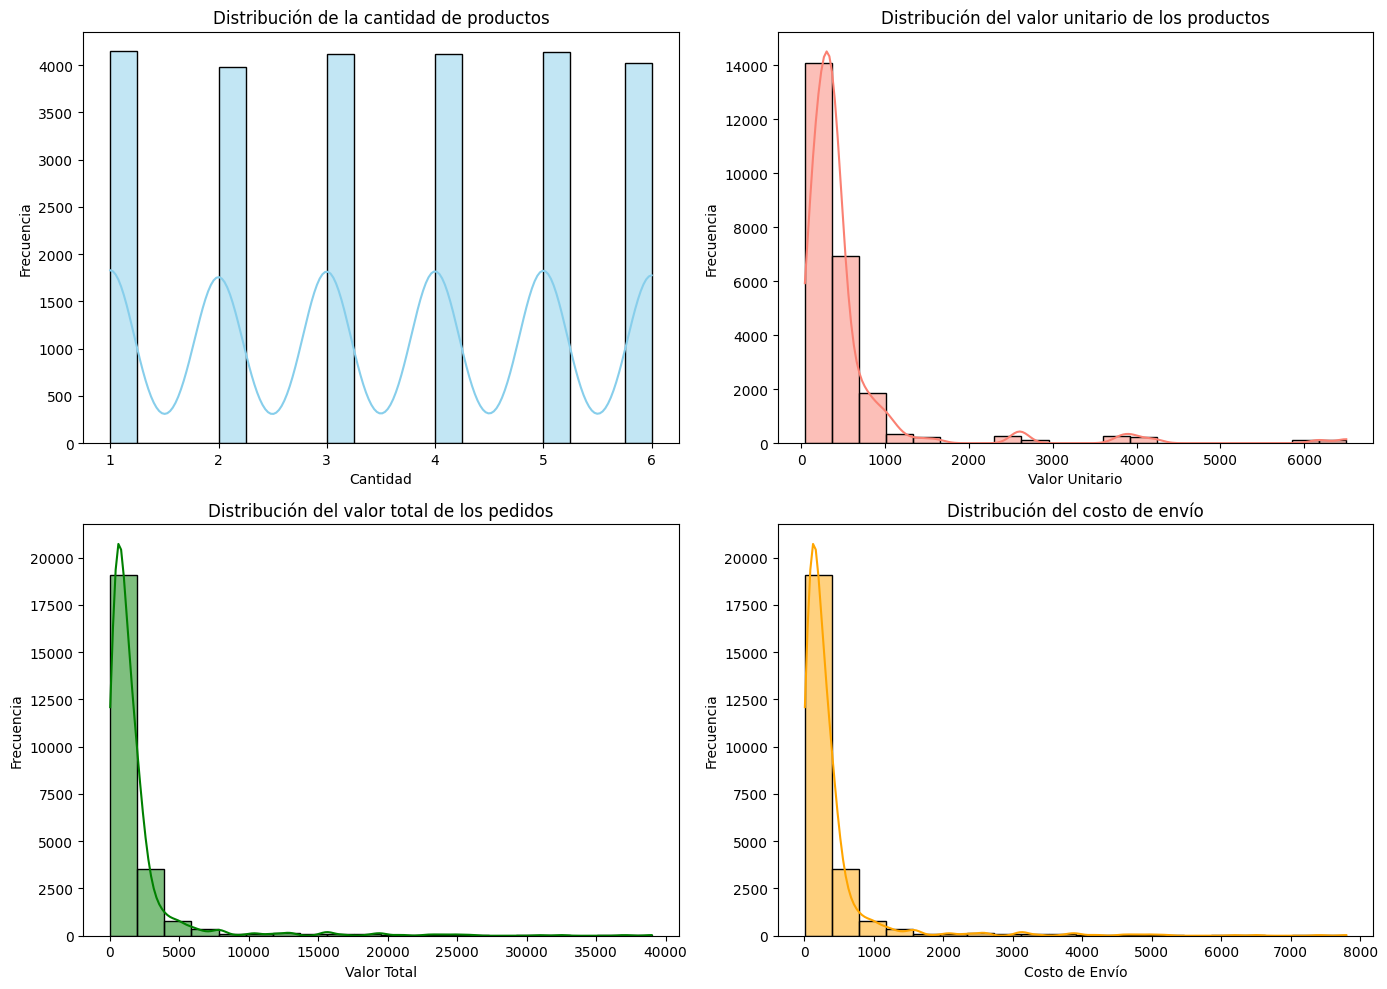

In [49]:
# Histogramas
warnings.filterwarnings("ignore", category=FutureWarning)
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(items_pedidos_procesados['cantidad'], bins=20, kde=True, color='skyblue')
plt.title('Distribución de la cantidad de productos')
plt.xlabel('Cantidad')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 2)
sns.histplot(items_pedidos_procesados['valor_unitario'], bins=20, kde=True, color='salmon')
plt.title('Distribución del valor unitario de los productos')
plt.xlabel('Valor Unitario')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 3)
sns.histplot(items_pedidos_procesados['valor_total'], bins=20, kde=True, color='green')
plt.title('Distribución del valor total de los pedidos')
plt.xlabel('Valor Total')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 4)
sns.histplot(items_pedidos_procesados['costo_envio'], bins=20, kde=True, color='orange')
plt.title('Distribución del costo de envío')
plt.xlabel('Costo de Envío')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


#### **Distribución de pedidos por cuidad**

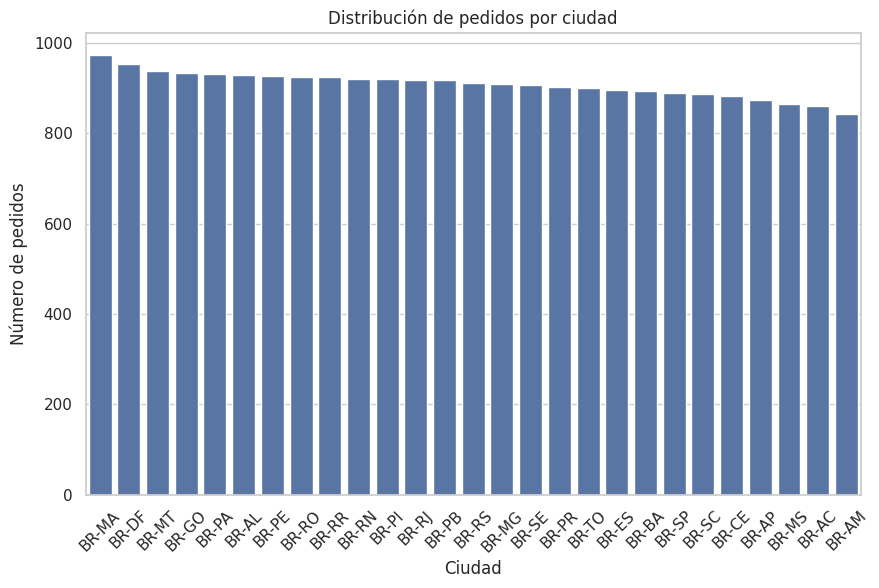

In [50]:
# Obtener el recuento de pedidos por ciudad y ordenar de mayor a menor
ciudades_ord = items_pedidos_procesados['ciudad'].value_counts().sort_values(ascending=False)

# Configuración de estilo
sns.set(style="whitegrid")

# Crear el gráfico de barras para los pedidos
plt.figure(figsize=(10, 6))
sns.barplot(x=ciudades_ord.index, y=ciudades_ord.values, order=ciudades_ord.index)
plt.title('Distribución de pedidos por ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Número de pedidos')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para una mejor visualización
plt.show()

#### **Diagrama de dispersión (exploración)**

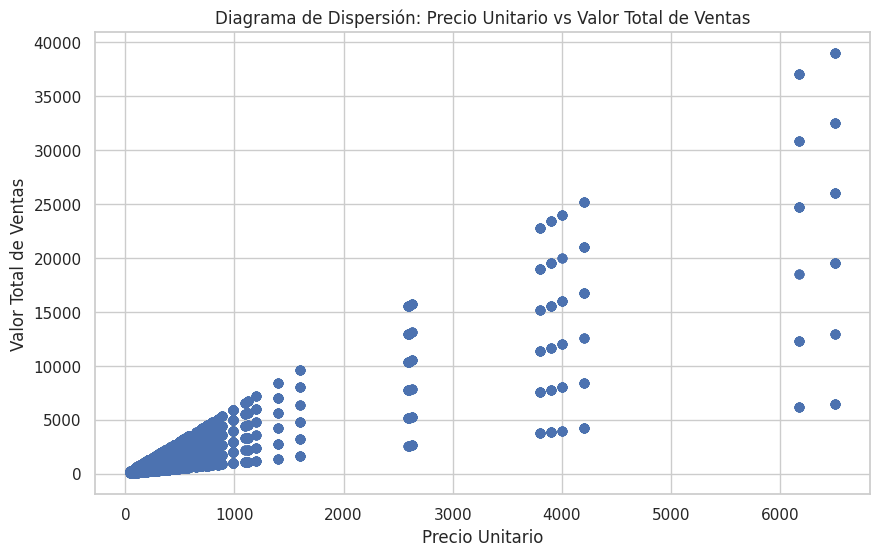

In [51]:
# Crear el diagrama de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(items_pedidos_procesados['valor_unitario'], items_pedidos_procesados['valor_total'], alpha=0.5)
plt.title('Diagrama de Dispersión: Precio Unitario vs Valor Total de Ventas')
plt.xlabel('Precio Unitario')
plt.ylabel('Valor Total de Ventas')
plt.grid(True)
plt.show()

#### **Boxplots **

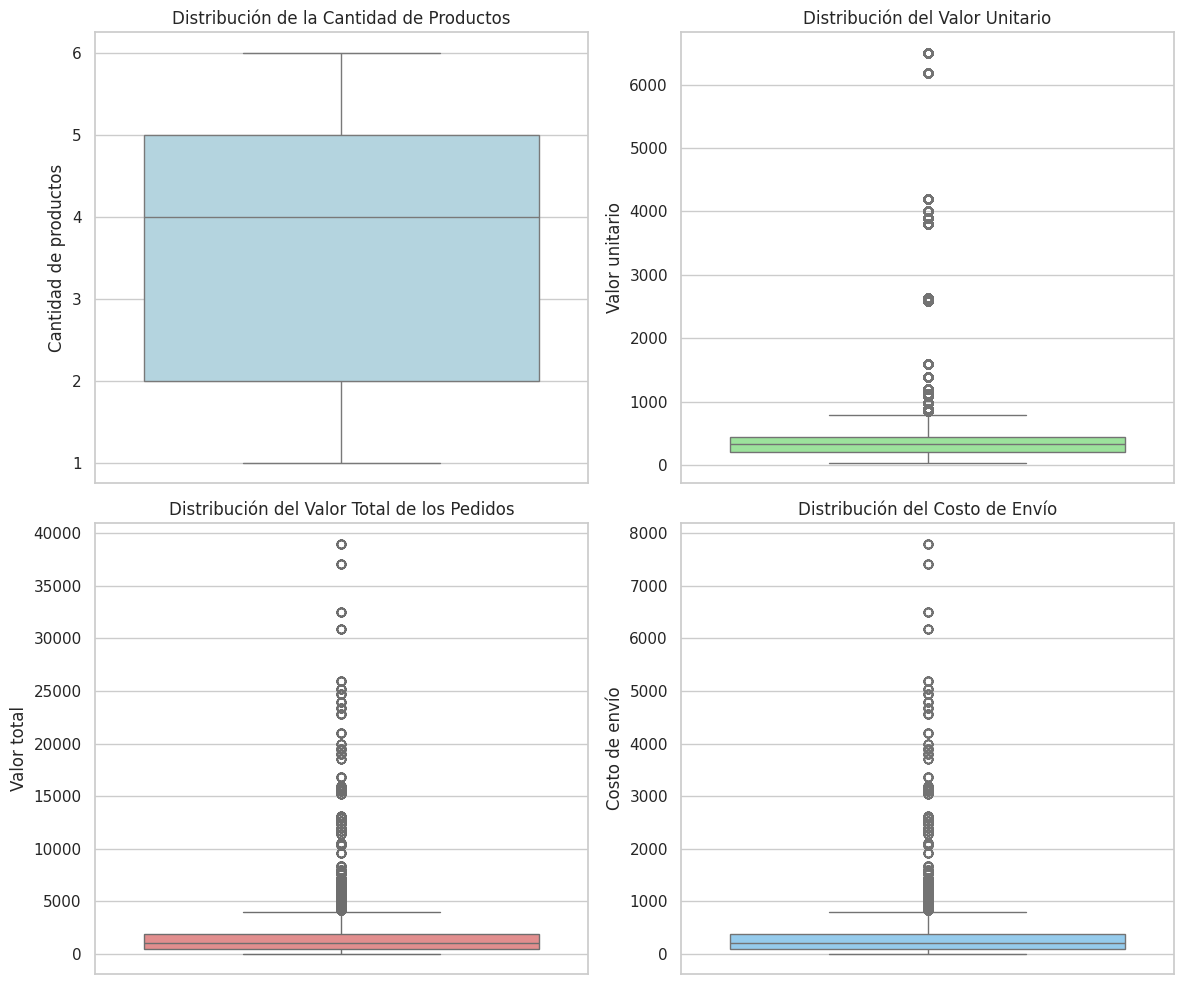

In [52]:
# Configuración de los estilos de Seaborn
sns.set(style="whitegrid")

# Crear una figura con subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Gráfico de caja para la cantidad de productos en los pedidos
sns.boxplot(data=items_pedidos_procesados['cantidad'], color='lightblue', ax=axs[0, 0])
axs[0, 0].set_title('Distribución de la Cantidad de Productos')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Cantidad de productos')

# Gráfico de caja para el valor unitario de los productos
sns.boxplot(data=items_pedidos_procesados['valor_unitario'], color='lightgreen', ax=axs[0, 1])
axs[0, 1].set_title('Distribución del Valor Unitario')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('Valor unitario')

# Gráfico de caja para el valor total de los pedidos
sns.boxplot(data=items_pedidos_procesados['valor_total'], color='lightcoral', ax=axs[1, 0])
axs[1, 0].set_title('Distribución del Valor Total de los Pedidos')
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('Valor total')

# Gráfico de caja para el costo de envío de los pedidos
sns.boxplot(data=items_pedidos_procesados['costo_envio'], color='lightskyblue', ax=axs[1, 1])
axs[1, 1].set_title('Distribución del Costo de Envío')
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('Costo de envío')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

### **2.3.2 Pedidos**

In [53]:
print("Información y descripción del dataframe de pedidos:")
print(pedidos_procesados.info())
print(pedidos_procesados.describe())
print("-----------------------------------------------------------")

Información y descripción del dataframe de pedidos:
<class 'pandas.core.frame.DataFrame'>
Index: 24526 entries, 1 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24526 non-null  int64         
 1   producto_id   24526 non-null  int64         
 2   vendedor_id   24526 non-null  int64         
 3   fecha_compra  24526 non-null  datetime64[ns]
 4   total         24526 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 1.1 MB
None
           pedido_id    producto_id   vendedor_id  \
count   24526.000000   24526.000000  24526.000000   
mean    69934.220501   44627.767961      2.975658   
min         1.000000    2706.000000      1.000000   
25%     34489.250000   17258.000000      2.000000   
50%     69946.000000   42913.000000      3.000000   
75%    105355.500000   70673.000000      4.000000   
max    139993.000000  100983.000000      5.000000   
std     4

In [54]:
pedidos_procesados.sample(5)

,pedido_id,producto_id,vendedor_id,fecha_compra,total
17037,15174,59784,3,2020-08-16,2340
24447,9670,42913,5,2021-02-20,7770
14405,73478,4553,4,2020-06-01,110
41,21847,14420,2,2019-01-18,1380
9859,417,55452,4,2020-02-11,700


#### **Histograma**

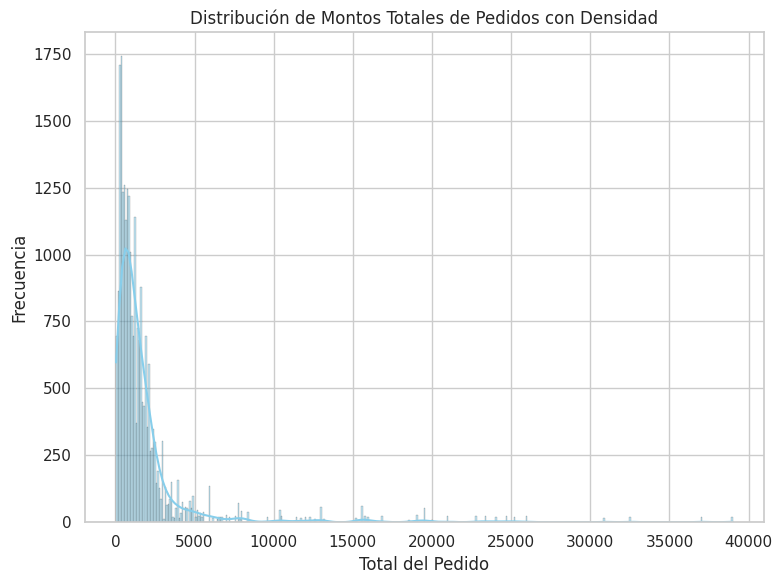

In [55]:
#Histograma de Total

plt.figure(figsize=(8, 6))
sns.histplot(pedidos_procesados['total'], kde=True, color='skyblue', edgecolor='black')
plt.title('Distribución de Montos Totales de Pedidos con Densidad')
plt.xlabel('Total del Pedido')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

#### **Pedidos por vendedor**

In [56]:
vendedores_procesados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   vendedor_id      5 non-null      int64 
 1   nombre_vendedor  5 non-null      object
dtypes: int64(1), object(1)
memory usage: 120.0+ bytes


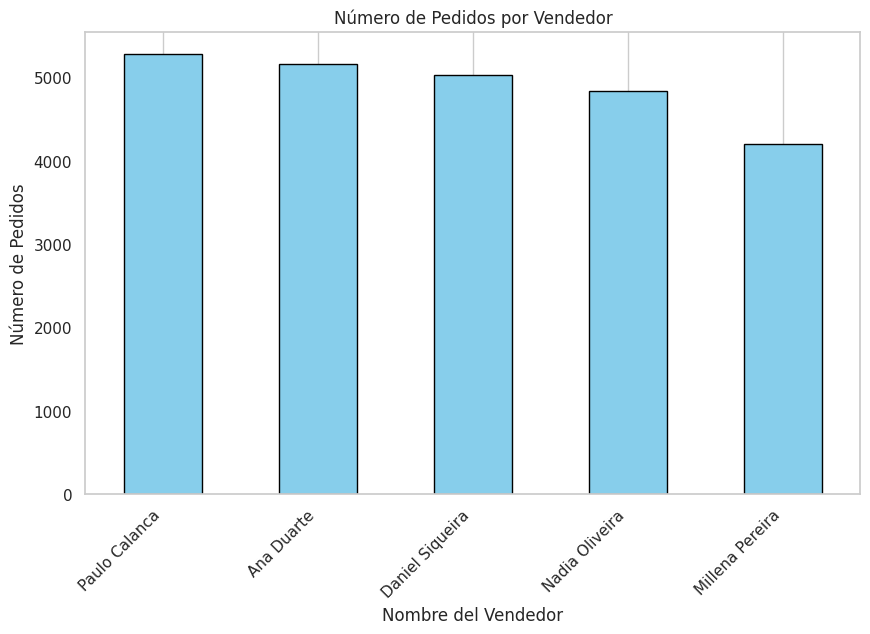

In [57]:
# Realizamos un join entre vendedor_procesado y pedidos_procesados
pedidos_vendedores = pd.merge(pedidos_procesados, vendedores_procesados, on='vendedor_id', how='left')

# Contamos el número de pedidos por vendedor
num_pedidos_por_vendedor = pedidos_vendedores['nombre_vendedor'].value_counts()

plt.figure(figsize=(10, 6))
num_pedidos_por_vendedor.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Número de Pedidos por Vendedor')
plt.xlabel('Nombre del Vendedor')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

### **2.3.3 Vendedores EDA**
--

In [58]:
fecha_inicio = "2019-01-01"
fecha_fin = "2019-02-01"
pedidos_procesados[pedidos_procesados['fecha_compra'].between(fecha_inicio, fecha_fin)]

,pedido_id,producto_id,vendedor_id,fecha_compra,total
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575
5,2980,72621,1,2019-01-05,537
...,...,...,...,...,...
149,91043,41189,2,2019-02-01,960
150,91541,61071,2,2019-02-01,2700
151,92175,17395,4,2019-02-01,2800
152,92176,17395,4,2019-02-01,2800


In [59]:
vendedores_procesados

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca


In [60]:
pedidos_procesados[pedidos_procesados['fecha_compra'].between(fecha_inicio, fecha_fin)]

,pedido_id,producto_id,vendedor_id,fecha_compra,total
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575
5,2980,72621,1,2019-01-05,537
...,...,...,...,...,...
149,91043,41189,2,2019-02-01,960
150,91541,61071,2,2019-02-01,2700
151,92175,17395,4,2019-02-01,2800
152,92176,17395,4,2019-02-01,2800


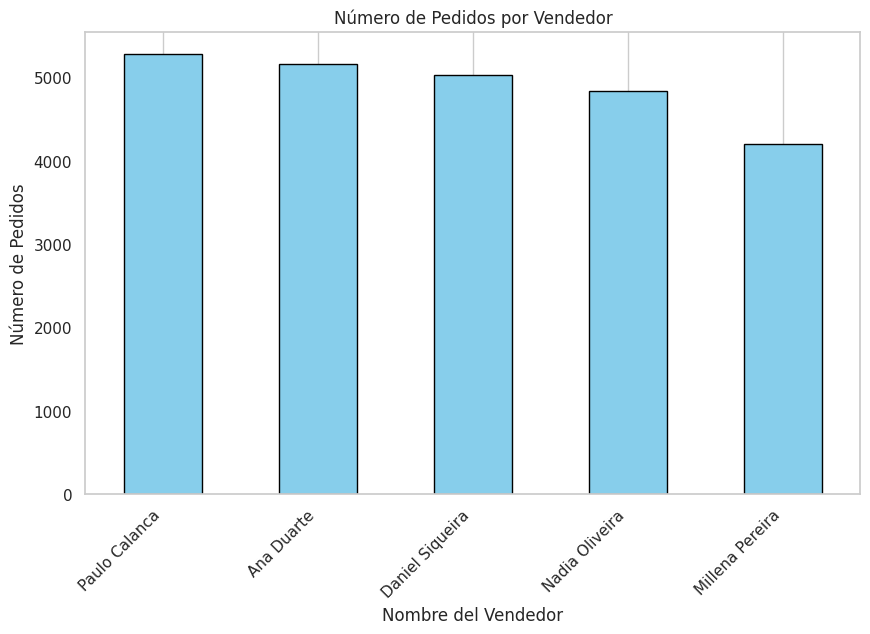

In [61]:
# Realizamos un join entre vendedor_procesado y pedidos_procesados
pedidos_vendedores = pd.merge(pedidos_procesados, vendedores_procesados, on='vendedor_id', how='left')

# Contamos el número de pedidos por vendedor
num_pedidos_por_vendedor = pedidos_vendedores['nombre_vendedor'].value_counts()

plt.figure(figsize=(10, 6))
num_pedidos_por_vendedor.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Número de Pedidos por Vendedor')
plt.xlabel('Nombre del Vendedor')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

#### **Dispersión fecha vs Total (exploración)**

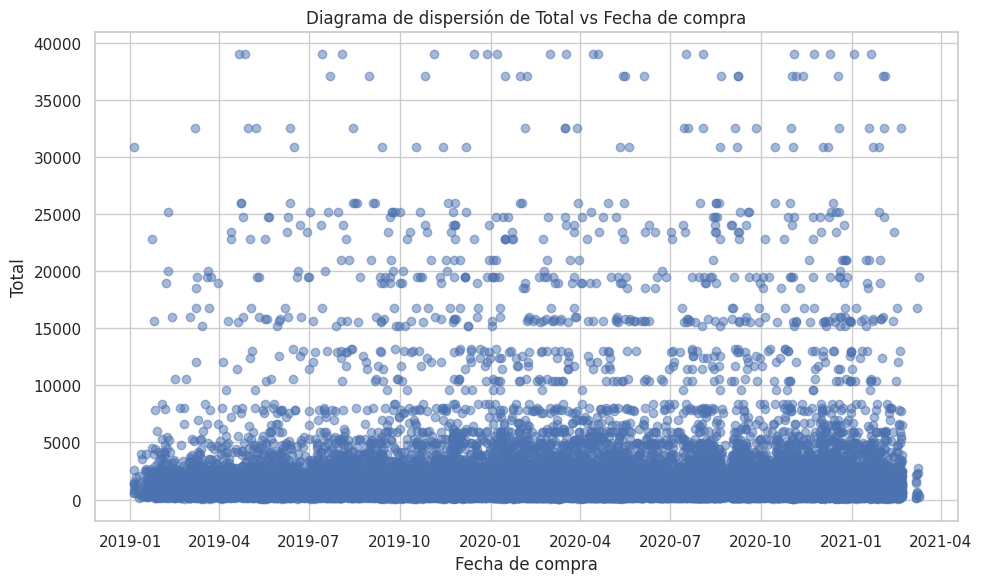

In [62]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(pedidos_procesados['fecha_compra'], pedidos_procesados['total'], alpha=0.5)

# Añadir etiquetas y título
plt.title('Diagrama de dispersión de Total vs Fecha de compra')
plt.xlabel('Fecha de compra')
plt.ylabel('Total')

# Mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Ventas por año y mes (Group by Mount and Year)**

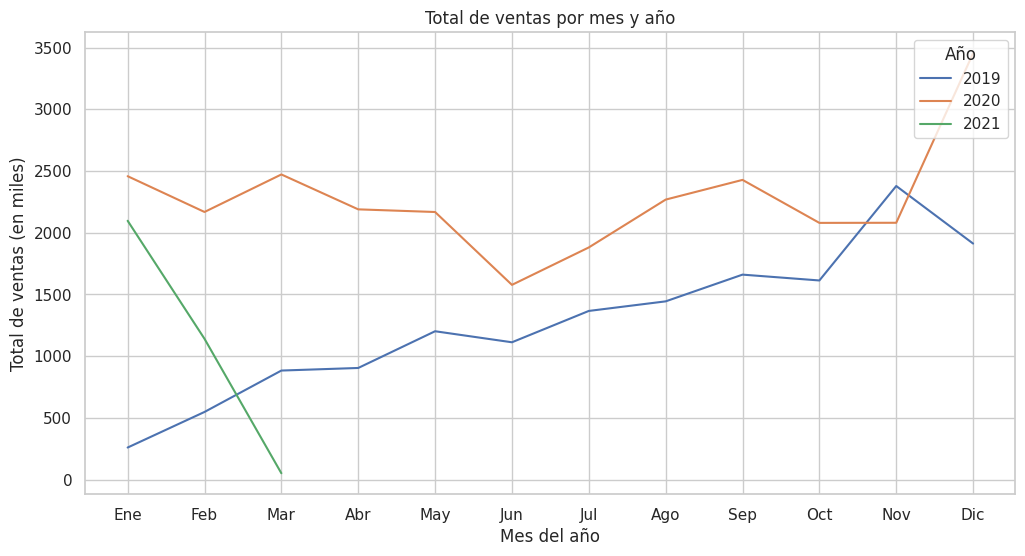

In [63]:
# Crear una nueva columna 'año' que represente el año en el que se realizó la compra
pedidos_procesados['año'] = pedidos_procesados['fecha_compra'].dt.year

# Crear una nueva columna 'mes' que represente el mes en el que se realizó la compra
pedidos_procesados['mes'] = pedidos_procesados['fecha_compra'].dt.month

# Agrupar los datos por año y mes y calcular el total de ventas para cada combinación
ventas_por_año_mes = pedidos_procesados.groupby(['año', 'mes'])['total'].sum().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
for año in ventas_por_año_mes['año'].unique():
    datos_año = ventas_por_año_mes[ventas_por_año_mes['año'] == año]
    plt.plot(datos_año['mes'], datos_año['total'] / 1000, label=str(año))

plt.xlabel('Mes del año')
plt.ylabel('Total de ventas (en miles)')
plt.title('Total de ventas por mes y año')
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.legend(title='Año', loc='upper right')
plt.grid(True)
plt.show()

#### **Boxplot**

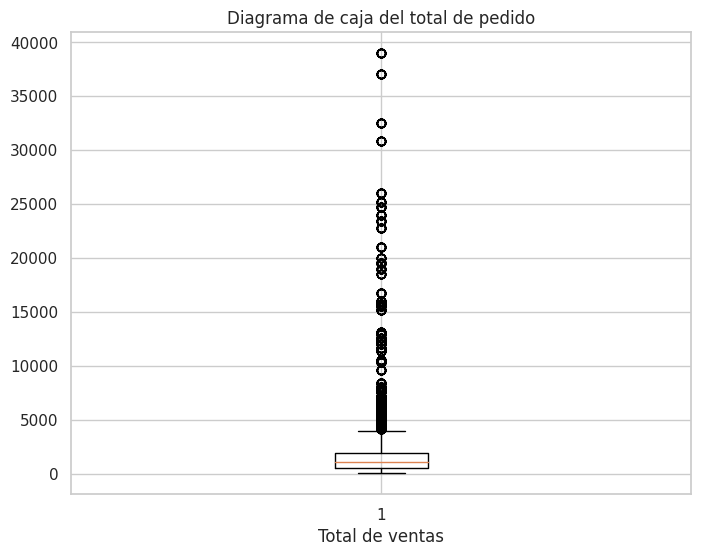

In [64]:
# Crear el diagrama de caja
plt.figure(figsize=(8, 6))
plt.boxplot(pedidos_procesados['total'])

plt.xlabel('Total de ventas')
plt.title('Diagrama de caja del total de pedido')
plt.grid(True)
plt.show()

### **2.3.4 Productos**

In [65]:

print("Información y descripción del dataframe de productos:")
print(productos_procesados.info())
print(productos_procesados.describe())
print("-----------------------------------------------------------")

Información y descripción del dataframe de productos:
<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 0 to 204
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   producto_id  205 non-null    int64  
 1   producto     205 non-null    object 
 2   precio       205 non-null    int64  
 3   marca        205 non-null    object 
 4   sku          205 non-null    float64
 5   condicion    205 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 11.2+ KB
None
         producto_id       precio            sku
count     205.000000   205.000000     205.000000
mean    44803.365854   536.009756  304625.234146
std     29419.632374   843.774387  190141.444036
min      2706.000000    45.000000  101494.000000
25%     17329.000000   210.000000  222028.000000
50%     43054.000000   336.000000  263899.000000
75%     70673.000000   450.000000  304828.000000
max    100983.000000  6500.000000  952821.000000
--

In [66]:
print("Cantidad de productos unicos: ", productos_procesados['producto'].value_counts())

Cantidad de productos unicos:  producto
Calca Alfaiataria Preta    2
Saia Pregas Preta          2
Vestido Recortes Cores     2
Calca Jeans Costuras       2
Oculos Lente Azulada       1
                          ..
Shorts Listras Bordados    1
Saia Lurex Color           1
Body Estampa Coracoes      1
Peeptoe Preto Verniz       1
Calca Jeans Basica         1
Name: count, Length: 201, dtype: int64


In [67]:
print("Cantidad de productos unicos: ", productos_procesados['marca'].value_counts())

Cantidad de productos unicos:  marca
Zara               23
Mixed              14
Animale             9
Le Lis Blanc        6
Banana Republic     5
                   ..
Thay Ribas          1
Carter’s            1
American Eagle      1
Isolda              1
Express             1
Name: count, Length: 117, dtype: int64


In [68]:
print("Cantidad de productos unicos: ", productos_procesados['condicion'].value_counts())

Cantidad de productos unicos:  condicion
Usado                 176
Nuevo con etiqueta     22
Nuevo sin etiqueta      7
Name: count, dtype: int64


#### **Productos por condición**

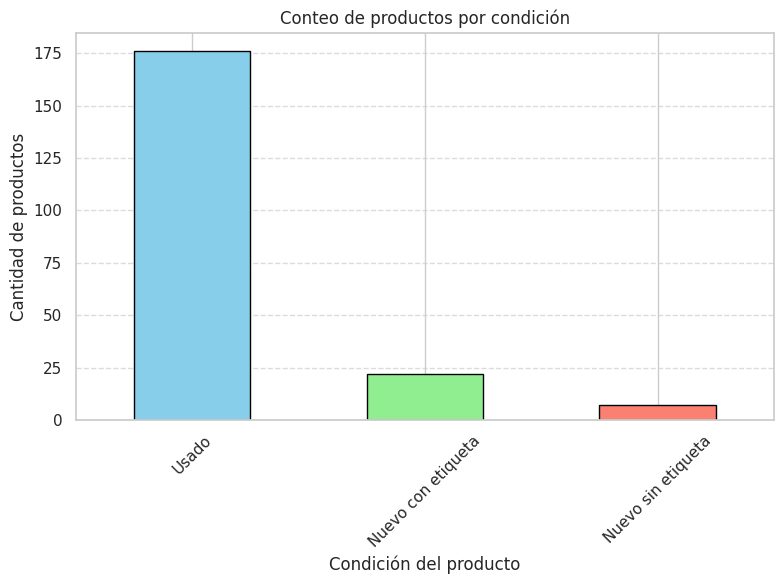

In [69]:
colors = ['skyblue', 'lightgreen', 'salmon']

# Crear un gráfico de barras para visualizar el conteo de productos por condición
plt.figure(figsize=(8, 6))
productos_procesados['condicion'].value_counts().plot(kind='bar', color=colors, edgecolor='black')
plt.title('Conteo de productos por condición')
plt.xlabel('Condición del producto')
plt.ylabel('Cantidad de productos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### **Boxplot de precios por condición**

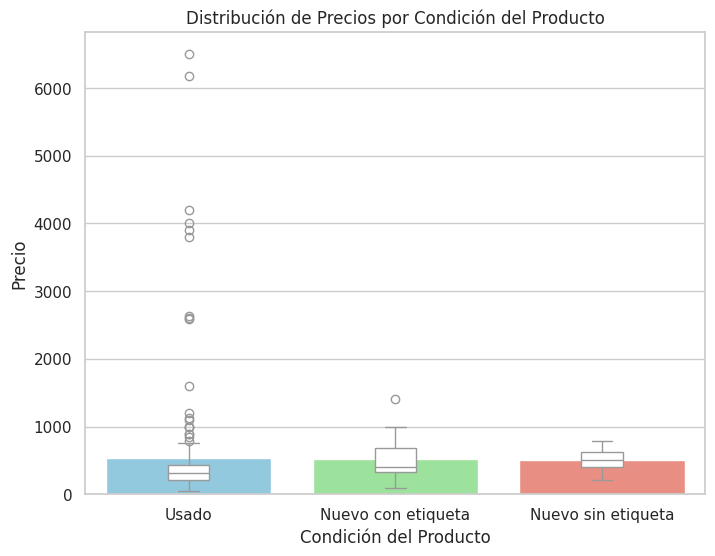

In [70]:
# Extraer los valores únicos de la columna 'condicion'
condiciones_unicas = productos_procesados['condicion'].unique()
colores_condicion = {condicion: color for condicion, color in zip(condiciones_unicas, ['skyblue', 'lightgreen', 'salmon'])}

# Crear el gráfico combinado de barras y diagrama de caja
plt.figure(figsize=(8, 6))
sns.barplot(x='condicion', y='precio', data=productos_procesados, palette=colores_condicion, ci=None)
sns.boxplot(x='condicion', y='precio', data=productos_procesados, color='white', width=0.2)

plt.title('Distribución de Precios por Condición del Producto')
plt.xlabel('Condición del Producto')
plt.ylabel('Precio')

# Mostrar el gráfico
plt.show()

#### **Precios por Condición del Producto**

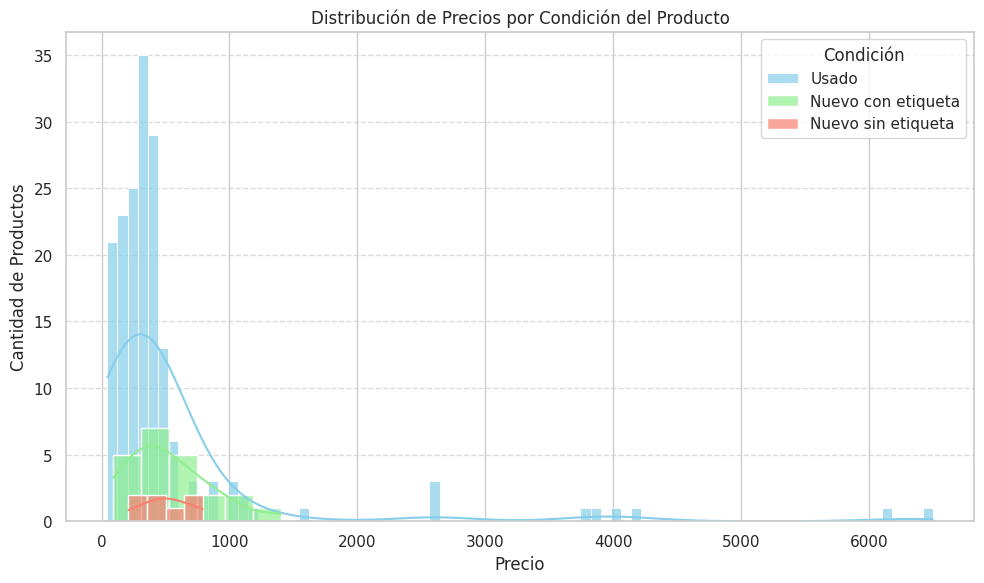

In [71]:
# Extraer los valores únicos de la columna de condición y eliminar espacios adicionales
condiciones_unicas = productos_procesados['condicion'].str.strip().unique()

# Crear un diccionario para mapear cada condición a un color
colores_condicion = {condicion: color for condicion, color in zip(condiciones_unicas, ['skyblue', 'lightgreen', 'salmon'])}

# Crear un gráfico de histograma para visualizar la distribución de precios por condición
plt.figure(figsize=(10, 6))
for condicion in condiciones_unicas:
    sns.histplot(data=productos_procesados[productos_procesados['condicion'].str.strip() == condicion],
                 x='precio', color=colores_condicion[condicion], label=condicion, kde=True, alpha=0.7)
plt.title('Distribución de Precios por Condición del Producto')
plt.xlabel('Precio')
plt.ylabel('Cantidad de Productos')
plt.legend(title='Condición')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **3 Banco de Datos**


---

###Renombrar dataframes

In [72]:
# Asignar los contenidos de los dataframes procesados a los dataframes originales
df_items_pedidos = items_pedidos_procesados.copy()
df_pedidos = pedidos_procesados.copy()
df_productos = productos_procesados.copy()
df_vendedores = vendedores_procesados.copy()

In [73]:
print("items pedidos ")
print(df_items_pedidos.info())
print("pedidos")
print(df_pedidos.info())
print("productos")
print(df_productos.info())
print("vendedores")
print(df_vendedores.info())

items pedidos 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 0 to 24525
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24526 non-null  int64  
 1   producto_id     24526 non-null  int64  
 2   pedido_id       24526 non-null  int64  
 3   cantidad        24526 non-null  int64  
 4   valor_unitario  24526 non-null  int64  
 5   valor_total     24526 non-null  int64  
 6   ciudad          24526 non-null  object 
 7   costo_envio     24526 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
pedidos
<class 'pandas.core.frame.DataFrame'>
Index: 24526 entries, 1 to 24526
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24526 non-null  int64         
 1   producto_id   24526 non-null  int64         
 2   vendedor_id   24526 non-null  int64         

## **3.1 Crear base de datos y motor**

####Función para CREAR base de datos en local

In [74]:
def crear_base_datos(dataframes, db_name, db_path):
    global df_items_pedidos, df_pedidos, df_productos, df_vendedores

    """
    Crea una base de datos y agrega los DataFrames como tablas.

    Args:
    - dataframes: Un diccionario donde las claves son los nombres de las tablas y los valores son los DataFrames.
    - db_name: El nombre de la base de datos a crear.
    - db_path: La ruta para guardar la base de datos.

    Returns:
    - None
    """
    # Crear engine
    engine = create_engine('sqlite:///' + db_path + db_name, echo=False)

    # Guardar DataFrames en la base de datos como tablas
    for table_name, df in dataframes.items():
        df.to_sql(table_name, con=engine, if_exists='replace', index=False)

    # Cerrar la conexión
    engine.dispose()

    print(f"Base de datos '{db_name}' creada y tablas agregadas.")

# # Ejemplo de uso
# dataframes = {
#     'items_pedidos': df_items_pedidos,
#     'pedidos': df_pedidos,
#     'productos': df_productos,
#     'vendedores': df_vendedores
# }
# db_name='database.db'
# db_path='/content/drive/MyDrive/Notebooks/Proyecto/'
# # Crear la base de datos y agregar los DataFrames
# crear_base_datos(dataframes,db_name=db_name,db_path=db_path)


####Crear Base de datos y tablas asociadas

In [75]:
dataframes = {
    'items_pedidos': df_items_pedidos,
    'pedidos': df_pedidos,
    'productos': df_productos,
    'vendedores': df_vendedores
}

db_name='database.db'
db_path='/content/drive/MyDrive/Colab Notebooks/Proyecto Store Sales Analysis/'

crear_base_datos(dataframes,db_name,db_path=db_path)

Base de datos 'database.db' creada y tablas agregadas.


## **3.2 Conectar con base de datos**

####Función para CONECTAR con base de datos

In [76]:
def crear_conexion(db_name, db_path):
    global df_items_pedidos, df_pedidos, df_productos, df_vendedores, engine
    # Crear la conexión a la base de datos
    engine = create_engine('sqlite:///' + db_path + db_name, echo=False)
    database = engine.connect()
    return database

####Crear CONEXIÓN con base de datos y acceder a consultas

In [77]:
# Llamar a la función para crear la conexión
db_name='database.db'
db_path='/content/drive/MyDrive/Colab Notebooks/Proyecto Store Sales Analysis/'

database = crear_conexion(db_name=db_name, db_path=db_path)

# Ahora puedes acceder a la variable "database"
# Usar el inspector para obtener información sobre las tablas y columnas
inspector = inspect(database)
print('Tablas: ', inspector.get_table_names(), '\n')
print('Columnas de Tabla Pedidos:')
for column in inspector.get_columns('pedidos'):
    print(column)

# # Cerrar la conexión
# database.close()

Tablas:  ['items_pedidos', 'pedidos', 'productos', 'vendedores'] 

Columnas de Tabla Pedidos:
{'name': 'pedido_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'producto_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'vendedor_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'fecha_compra', 'type': DATETIME(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'total', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'año', 'type': INTEGER(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'mes', 'type': INTEGER(), 'nullable': True, 'default': None, 'primary_key': 0}


####Realizando una consulta

In [78]:
# Definir otra consulta SQL
query = """SELECT * FROM vendedores WHERE vendedor_id=5 """

# Ejecutar la consulta SQL y cargar los resultados en un DataFrame
df_ejemplo = pd.read_sql(sql=text(query), con=database)
df_ejemplo
# Cerrar la conexión
# database.close()

,vendedor_id,nombre_vendedor
0,5,Paulo Calanca


# **1. ¿Cual es el Top 5 productos más vendidos históricamente?**

## **1.1 Obtención de datos (Motor DB)**

In [79]:
consulta_sql = text("""
SELECT p.producto_id, p.producto, p.marca,
      SUM(i.cantidad) AS cantidad_vendida,
      SUM(i.cantidad * pr.precio) AS monto_total
FROM productos p
INNER JOIN items_pedidos i ON p.producto_id = i.producto_id
INNER JOIN productos pr ON p.producto_id = pr.producto_id
GROUP BY p.producto_id, p.producto, p.marca
ORDER BY cantidad_vendida DESC
LIMIT 5

""")


# Ejecutar la consulta SQL y cargar los resultados en un DataFrame
resultados = database.execute(consulta_sql)

# Guardar los resultados en un DataFrame
df = pd.DataFrame(resultados, columns=['producto_id', 'producto', 'marca', 'cantidad_vendida', 'monto_total'])
df["monto_total"] = (df["monto_total"]/1000).apply(lambda x: f'${x:.0f}K')


In [80]:
df

,producto_id,producto,marca,cantidad_vendida,monto_total
0,32126,Saia Midi Cinto,Limone By Jade Seba,549,$115K
1,13814,Vestido Nude Reta,Ellus,547,$301K
2,47405,Blusa Manga Estampa,Animale,536,$166K
3,33976,Camisa Xadrez Azul,Hollister,511,$61K
4,53941,Cropped Escritas Pb,Linda de Morrer,508,$142K


## **1.2 ¿Cual es el Top 5 productos más vendidos históricamente?**

In [81]:
images_path = ['blusa.png', 'blusa.png', 'blusa.png', 'blusa.png', 'blusa.png']

FileNotFoundError: [Errno 2] No such file or directory: 'blusa.png'

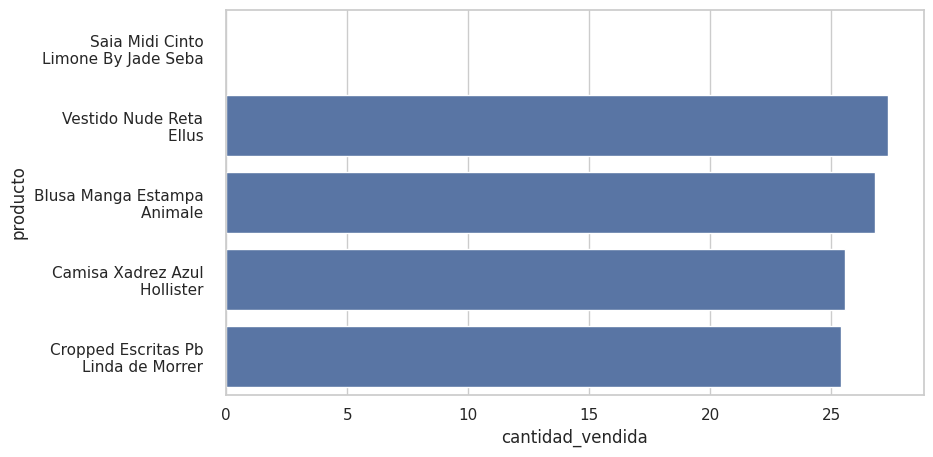

In [82]:
# Concatenar nombre y marca en una sola columna
df['producto'] = df['producto'] +'  '+ '\n' + df['marca'] +'  '

# Crear la figura con el tamaño deseado
plt.figure(figsize=(9, 5))

# Crear el gráfico de barras horizontal
ax = sns.barplot(x=df.cantidad_vendida / 20, y=df.producto, orient='h', joinstyle='bevel')

# Definir colores pasteles para las barras
colores_pastel = ['#9BDD70', '#6BC4D1', '#D18BC4', '#BAC56B', '#7070D1']

new_patches = []
for i, patch, producto, cantidad_vendida, monto_total, image_path, color in zip(range(len(df)), ax.patches, df['producto'], df['cantidad_vendida'], df['monto_total'], images_path, colores_pastel):
    bb = patch.get_bbox()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle='round,pad=0.04,rounding_size=0.73',
                            ec="none", fc=color,
                            mutation_aspect=0.73)
    patch.remove()
    new_patches.append(p_bbox)

    # Añadir imagen dentro de la barra
    image = plt.imread(image_path)
    imagebox = OffsetImage(image, zoom=1.19)
    ab = AnnotationBbox(imagebox, xy=(1.3, patch.get_y() + patch.get_height() / 2),
                        xybox=(0, 0), xycoords='data', boxcoords="offset points",
                        pad=0, arrowprops=dict(arrowstyle='-', color='none'),
                        bboxprops=dict(facecolor='none', edgecolor='none'))
    ax.add_artist(ab)

    # Añadir texto (cantidad_vendida) al lado izquierdo de la barra
    ax.annotate(f'{cantidad_vendida}', xy=(patch.get_width(), patch.get_y() + patch.get_height() / 2),
                xytext=(-5, 0), textcoords='offset points',
                arrowprops=dict(arrowstyle='-', color='none'),
                color='white', fontweight='bold', fontsize=12, ha='right', va='center',
                xycoords='data',
                bbox=dict(facecolor='none', edgecolor='none', pad=0),
                annotation_clip=False)

    # Añadir texto (monto_total) al lado derecho de la barra
    ax.annotate(f'{monto_total}', xy=(6.1, patch.get_y() + patch.get_height() / 2),
                xytext=(-5, 0), textcoords='offset points',
                arrowprops=dict(arrowstyle='-', color='none'),
                color='white', fontweight='bold', fontsize=12, ha='right', va='center',
                xycoords='data',
                bbox=dict(facecolor='none', edgecolor='none', pad=0),
                annotation_clip=False)

for patch in new_patches:
    ax.add_patch(patch)

sns.despine(left=True, bottom=True)
sns.despine(left=True)  # Eliminar los bordes izquierdos
plt.title('Top 5 productos más vendidos históricamente', fontsize=15)
plt.ylabel('')  # Eliminar el texto del eje y
plt.xlabel('')  # Eliminar el texto del eje x
plt.grid(False)  # Eliminar la cuadrícula
plt.xticks([])  # Eliminar las marcas del eje x
plt.yticks(fontsize=12)  # Ajustar el tamaño de la fuente en el eje y

ax.tick_params(axis=u'both', which=u'both', length=0)
plt.tight_layout()

# Eliminar la etiqueta del eje x
ax.xaxis.label.set_visible(False)

# Mostrar el gráfico
plt.show()

#**Pregunta 2: ¿Cual es la evolución histórica de las ingresos netos?**

####SQL y dataframe

In [83]:
# Definir la consulta SQL
consulta_sql = text("""
SELECT
    p.fecha_compra AS fecha,
    strftime('%Y', p.fecha_compra) AS año,
    strftime('%m', p.fecha_compra) AS mes,
    strftime('%d', p.fecha_compra) AS dia,
    (p.total - i.costo_envio) AS ingreso_neto,
    pr.marca AS marca,
    pr.producto AS producto
FROM
    pedidos p
INNER JOIN
    items_pedidos i ON p.pedido_id = i.pedido_id
INNER JOIN
    productos pr ON i.producto_id = pr.producto_id

""")

# Ejecutar la consulta SQL y cargar los resultados en un DataFrame
resultados = database.execute(consulta_sql)

# Guardar los resultados en un DataFrame
df_ingreso_neto= pd.DataFrame(resultados)
df_ingreso_neto

,fecha,año,mes,dia,ingreso_neto,marca,producto
0,2019-01-05 00:00:00.000000,2019,01,05,24700.0,Bottega Veneta,Bolsa Intrecciato Caramelo
1,2019-01-05 00:00:00.000000,2019,01,05,480.0,Topshop,Cropped Listras Florzinhas
2,2019-01-05 00:00:00.000000,2019,01,05,667.2,Lezalez,Shorts Jeans Tye Dye
3,2019-01-05 00:00:00.000000,2019,01,05,1260.0,Tigresse,Casaco Branco Costuras
4,2019-01-05 00:00:00.000000,2019,01,05,429.6,Zara,Capa Fio Marrom
...,...,...,...,...,...,...,...
24521,2021-03-09 00:00:00.000000,2021,03,09,1888.0,J. Crew,Vestido Textura Branco
24522,2021-03-09 00:00:00.000000,2021,03,09,2240.0,Animale,Jaqueta Veludo Bordada
24523,2021-03-10 00:00:00.000000,2021,03,10,15600.0,Christian Louboutin,Sapato Cetim Pink
24524,2021-03-10 00:00:00.000000,2021,03,10,333.6,Lezalez,Shorts Jeans Tye Dye


###Ingreso neto promedio diario total periodo

In [84]:
# Definir la consulta SQL
consulta_sql = text("""

SELECT AVG(total - costo_envio) AS ingreso_neto_promedio_diario_total
FROM pedidos p
JOIN items_pedidos i ON p.pedido_id = i.pedido_id;

""")

# Ejecutar la consulta SQL y cargar los resultados en un DataFrame
promedio_neto_total = database.execute(consulta_sql)

# Guardar los resultados en un DataFrame
df_ingreso_prom_neto_diario_total= pd.DataFrame(promedio_neto_total)
df_ingreso_prom_neto_diario_total







,ingreso_neto_promedio_diario_total
0,1494.027563


###Ingreso neto promedio diario  por año.

In [85]:
# Definir la consulta SQL
consulta_sql = text("""
SELECT strftime('%Y', fecha_compra) AS año,
       AVG(total - costo_envio) AS ingreso_neto_promedio_diario
FROM pedidos p
JOIN items_pedidos i ON p.pedido_id = i.pedido_id
GROUP BY strftime('%Y', fecha_compra);



""")

# Ejecutar la consulta SQL y cargar los resultados en un DataFrame
promedio_neto_diario_año = database.execute(consulta_sql)

# Guardar los resultados en un DataFrame
df_ingreso_prom_neto_diario_año= pd.DataFrame(promedio_neto_diario_año )
df_ingreso_prom_neto_diario_año


,año,ingreso_neto_promedio_diario
0,2019,1497.583737
1,2020,1497.542853
2,2021,1449.856970


###Ingreso neto promedio diario  desde 2020.

In [86]:
# Definir la consulta SQL
consulta_sql = text("""

SELECT AVG(total - costo_envio) AS ingreso_neto_promedio_diario_desde_2020
FROM pedidos p
JOIN items_pedidos i ON p.pedido_id = i.pedido_id
WHERE strftime('%Y', fecha_compra) >= '2020';



""")

# Ejecutar la consulta SQL y cargar los resultados en un DataFrame
promedio_neto_diario_desde2020 = database.execute(consulta_sql)

# Guardar los resultados en un DataFrame
df_ingreso_prom_neto_diario_desde2020= pd.DataFrame(promedio_neto_diario_desde2020 )
df_ingreso_prom_neto_diario_desde2020







,ingreso_neto_promedio_diario_desde_2020
0,1492.252518


In [87]:
df_ingreso_prom_neto_diario_desde2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 1 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ingreso_neto_promedio_diario_desde_2020  1 non-null      float64
dtypes: float64(1)
memory usage: 136.0 bytes


In [88]:
df_ingreso_neto.describe()

,ingreso_neto
count,24526.000000
mean,1494.027563
std,2703.794924
min,36.000000
25%,416.000000
50%,840.000000
75%,1536.000000
max,31200.000000


###Preparación de dataframe para graficar histórico de ingresos netos

In [89]:
# Convertir la columna 'fecha' a tipo de datos datetime en el formato correcto

df_ingreso_neto['fecha'] = pd.to_datetime(df_ingreso_neto['fecha'])

# Agrupar los datos por día y calcular las ventas netas diarias
ventas_diarias = df_ingreso_neto.groupby('fecha')['ingreso_neto'].sum()

# Convertir el índice a tipo datetime
ventas_diarias.index = pd.to_datetime(ventas_diarias.index)


# #Crear nueva columna formateada a miles en el ingreso neto
# df_ingresos['Ingreso_neto(K)']=(df_ingresos["Ingreso neto"]/1000).round(4).apply(lambda x: f'${x:.4f}K')

In [90]:
print(df_ingreso_neto.info())
print("--------------------")
print(ventas_diarias.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 0 to 24525
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   fecha         24526 non-null  datetime64[ns]
 1   año           24526 non-null  object        
 2   mes           24526 non-null  object        
 3   dia           24526 non-null  object        
 4   ingreso_neto  24526 non-null  float64       
 5   marca         24526 non-null  object        
 6   producto      24526 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 1.3+ MB
None
--------------------
<class 'pandas.core.series.Series'>
DatetimeIndex: 780 entries, 2019-01-05 to 2021-03-10
Series name: ingreso_neto
Non-Null Count  Dtype  
--------------  -----  
780 non-null    float64
dtypes: float64(1)
memory usage: 12.2 KB
None


####Ventas del 24 de Noviembre de 2019

In [91]:
#**Ventas netas el 24-11-2019**

# Filtrar los datos para obtener solo las ventas del día 24 de noviembre de 2019
ventas_24_nov_2019 = df_ingreso_neto[df_ingreso_neto['fecha'] == '2019-11-24']

# Calcular la suma total de ingresos netos para ese día
suma_ventas_24_nov_2019 = ventas_24_nov_2019['ingreso_neto'].sum()


# Filtrar los datos para obtener las ganancias netas del 24 de noviembre de 2019
ganancias_24nov = df_ingreso_neto[df_ingreso_neto['fecha'] == '2019-11-24']

# Calcular las ganancias netas por marca
ganancias_por_marca = ganancias_24nov.groupby('marca')['ingreso_neto'].sum()

# Ordenar las marcas por ganancias netas en orden descendente y seleccionar las 5 primeras
top_5_marcas = ganancias_por_marca.nlargest(5)

# Calcular el total de ganancias netas para las 5 principales marcas
total_top_5 = top_5_marcas.sum()

# Calcular el resto de las ganancias netas
resto = ganancias_por_marca.sum() - total_top_5

# Crear un DataFrame con las 5 principales marcas y el resto
data = pd.concat([top_5_marcas, pd.Series(resto, index=['Otros'])])


##Visualización Evolución Histórica de ingresos

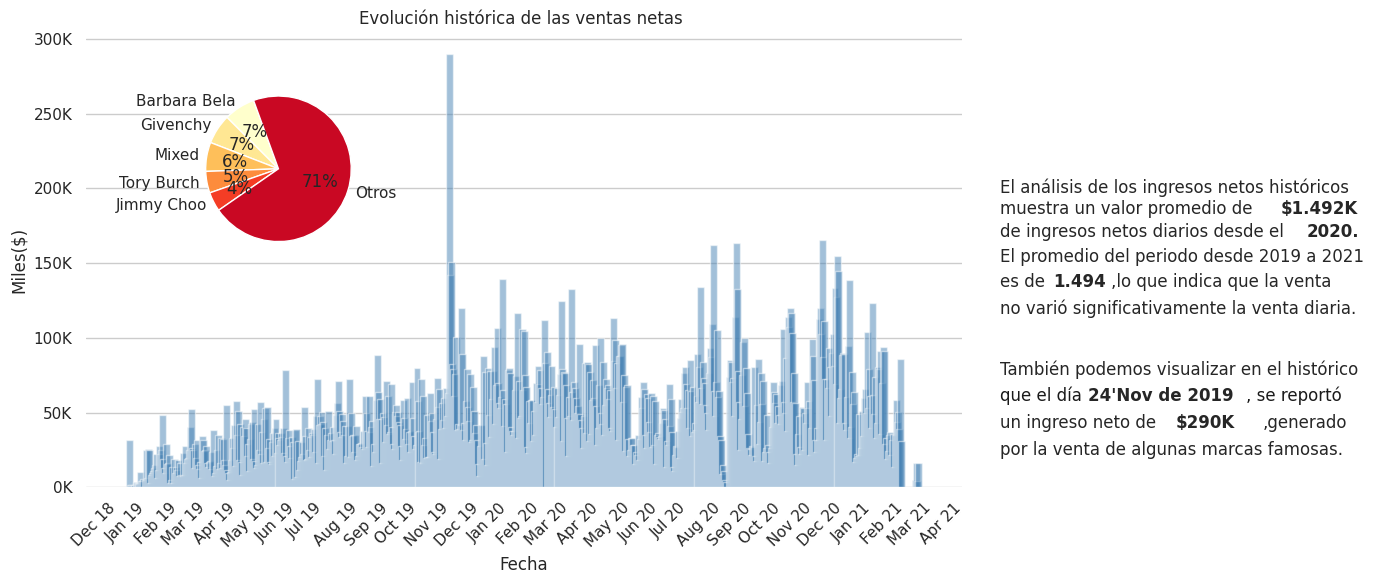

In [171]:
# Configurar el gráfico con subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [5, 1]})

# Graficar las ventas netas diarias
ax1.bar(ventas_diarias.index, ventas_diarias.values, color='steelblue', label='Ventas Netas Diarias', width=7, alpha=0.5)

# Configurar los ejes y el título
ax1.set_title('Evolución histórica de las ventas netas ')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Miles($)')
ax1.xaxis.set_major_locator(mdates.MonthLocator())  # Mostrar cada mes en el eje X
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))  # Formatear las etiquetas del eje X como "Jan 19", "Feb 19", etc.
ax1.tick_params(axis='x', rotation=45)  # Rotar las etiquetas del eje X para mejor legibilidad
# ax1.legend()  # Mostrar la leyenda

# Formatear los valores de los ingresos netos en la escala de miles(K)
formatter = plt.FuncFormatter(lambda x, _: '{:,.0f}K'.format(x/1000))
ax1.yaxis.set_major_formatter(formatter)

# Graficar el gráfico de torta de distribución de ganancias netas por marca el 24 de Noviembre de 2019

# Crear una paleta de colores degradada de azul
num_segmentos = 6
colores = [cm.YlOrRd(i/num_segmentos) for i in range(num_segmentos)]
#pink, hot
# Graficar la distribución en un gráfico de torta
ax_torta = ax1.inset_axes([0.02, 0.5, 0.4, 0.4])  # Insertar un eje para el gráfico de torta
ax_torta.pie(data, labels=data.index, autopct='%1.0f%%', startangle=110, colors=colores)
ax_torta.set_title('')  # Quitar el título del gráfico de torta

# Anotar la relación entre el gráfico de torta y la fecha en el gráfico de barras
ax1.annotate('', xy=(ventas_diarias.index[280], 260e3), xytext=(ventas_diarias.index[250], 280e3),
             arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3,rad=0.5'))

# Eliminar la visualización del marco del gráfico
ax1.set_frame_on(False)

# Trazar líneas suaves en cada nivel del eje y
ax1.grid(axis='x')

# Agregar el texto adicional en el segundo subplot
# Crear comentarios del análisis del gráfico
analisis = "El análisis de los ingresos netos históricos\nmuestra un valor promedio de"
ax2.text(0.1, 0.6, analisis, fontsize=12)
# Mostrar el valor promedio de ingreso neto diario
ax2.text(1.7, 0.6, "${:.3f}K".format(df_ingreso_prom_neto_diario_desde2020.iloc[0, 0]/1e3), fontsize=12, fontweight="bold")
ax2.text(0.1, 0.55, "de ingresos netos diarios desde el", fontsize=12)
ax2.text(1.85, 0.55, "2020.", fontsize=12, fontweight="bold")
ax2.text(0.1, 0.45, "El promedio del periodo desde 2019 a 2021\n", fontsize=12)
ax2.text(0.1, 0.44, "es de ", fontsize=12)
ax2.text(0.4, 0.44, "1.494", fontsize=12, fontweight="bold")
ax2.text(0.73, 0.44, ",lo que indica que la venta", fontsize=12)
ax2.text(0.1, 0.38, "no varió significativamente la venta diaria.", fontsize=12)
ax2.text(0.1, 0.20, "También podemos visualizar en el histórico\n", fontsize=12)
ax2.text(0.1, 0.19, "que el día", fontsize=12, color="k")
ax2.text(0.6, 0.19, "24'Nov de 2019", fontsize=12, fontweight="bold")
ax2.text(1.5, 0.19, ", se reportó", fontsize=12, color="k")
ax2.text(0.1, 0.13, "un ingreso neto de", fontsize=12)
ax2.text(1.1, 0.13, "${:.0f}K".format(suma_ventas_24_nov_2019/1e3), fontsize=12, fontweight="bold")
ax2.text(1.6, 0.13, ",generado", fontsize=12)
ax2.text(0.1, 0.07, "por la venta de algunas marcas famosas.", fontsize=12)

# Quitar ejes del segundo subplot
ax2.axis('off')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


#**Pregunta 3: ¿Cuáles son los ingresos netos por vendedor por año?**

###Realizamos la consulta sql

In [93]:
# Definir la consulta SQL

consulta_sql = text("""
SELECT
    nombre_vendedor,
    SUM((strftime('%Y', fecha_compra) = '2019') * (total - costo_envio)) AS "Año 2019",
    SUM((strftime('%Y', fecha_compra) = '2020') * (total - costo_envio)) AS "Año 2020",
    SUM((strftime('%Y', fecha_compra) = '2021') * (total - costo_envio)) AS "Año 2021"
FROM
    pedidos p
INNER JOIN
    items_pedidos ip ON p.pedido_id = ip.pedido_id
INNER JOIN
    vendedores v ON p.vendedor_id = v.vendedor_id
GROUP BY
    nombre_vendedor;

""")

# Ejecutar la consulta SQL y cargar los resultados en un DataFrame
consulta_vendedor = database.execute(consulta_sql)

# Guardar los resultados en un DataFrame
df_ingreso_vendedor= pd.DataFrame(consulta_vendedor)
df_ingreso_vendedor

,nombre_vendedor,Año 2019,Año 2020,Año 2021
0,Ana Duarte,2154261.6,5054009.6,547470.4
1,Daniel Siqueira,2020503.2,5266932.8,419702.4
2,Millena Pereira,2054682.4,3804385.6,398896.0
3,Nadia Oliveira,2296986.4,4046902.4,810020.0
4,Paulo Calanca,3702835.2,3609530.4,455401.6


In [94]:
# Establecer la columna 'nombre_vendedor' como el índice del DataFrame
df_ingreso_vendedor.set_index('nombre_vendedor', inplace=True)


In [95]:
# Crear un DataFrame con los nombres de los vendedores
nombres = [nombre.split()[0] for nombre in df_ingreso_vendedor.index]
df_nombres = pd.DataFrame(nombres, columns=['nombre'])

# Imprimir el DataFrame de nombres de vendedores
print(df_nombres)


    nombre
0      Ana
1   Daniel
2  Millena
3    Nadia
4    Paulo


In [96]:
print(df_ingreso_vendedor.info())
print("------------------------")
print(df_ingreso_vendedor.head())

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, Ana Duarte to Paulo Calanca
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Año 2019  5 non-null      float64
 1   Año 2020  5 non-null      float64
 2   Año 2021  5 non-null      float64
dtypes: float64(3)
memory usage: 160.0+ bytes
None
------------------------
                  Año 2019   Año 2020  Año 2021
nombre_vendedor                                
Ana Duarte       2154261.6  5054009.6  547470.4
Daniel Siqueira  2020503.2  5266932.8  419702.4
Millena Pereira  2054682.4  3804385.6  398896.0
Nadia Oliveira   2296986.4  4046902.4  810020.0
Paulo Calanca    3702835.2  3609530.4  455401.6


###Creando el grafico

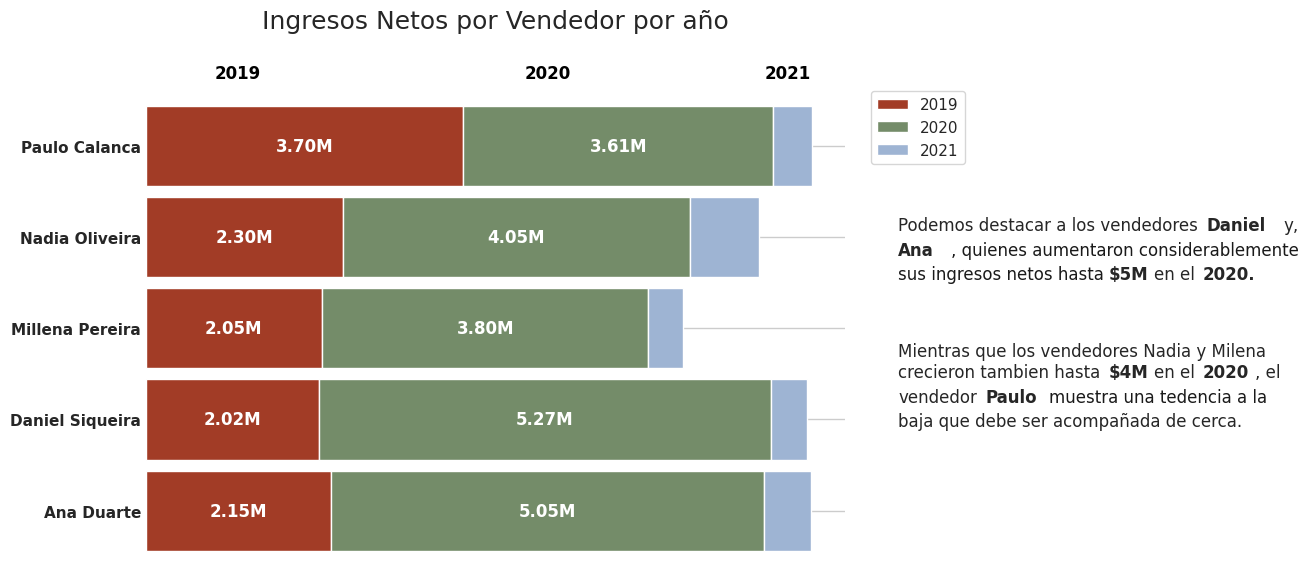

In [97]:
# Obtener los nombres de los vendedores
vendedores = df_ingreso_vendedor.index

# Obtener los valores de los ingresos netos por año
ingresos_2019 = df_ingreso_vendedor['Año 2019']
ingresos_2020 = df_ingreso_vendedor['Año 2020']
ingresos_2021 = df_ingreso_vendedor['Año 2021']

# Crear el gráfico de barras horizontales apiladas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})

# Posición de los vendedores en el gráfico
pos = np.arange(len(vendedores))

# Crear las barras horizontales apiladas con barras más anchas
bar_width = 0.88
# Colores más modernos
colors = ['#A23C26', '#748C69', '#9EB4D3']

# Crear las barras horizontales apiladas con colores
bar_2019 = ax1.barh(pos, ingresos_2019, height=bar_width, color=colors[0], label='Año 2019')
bar_2020 = ax1.barh(pos, ingresos_2020, left=ingresos_2019, height=bar_width, color=colors[1], label='Año 2020')
bar_2021 = ax1.barh(pos, ingresos_2021, left=ingresos_2019+ingresos_2020, height=bar_width, color=colors[2], label='Año 2021')


# Configurar el título y las etiquetas de los ejes
ax1.set_title('Ingresos Netos por Vendedor por año', fontsize=18, pad=40)  # Tamaño del título y separación
ax1.set_yticks(pos)
ax1.set_yticklabels(vendedores, fontweight='bold')  # Agregar los nombres de los vendedores en el eje y en negrita
ax1.xaxis.set_visible(False)

# Mostrar los valores de ingresos netos en negrita y con un tamaño de fuente mayor en cada barra
for b2019, b2020, b2021, vendedor in zip(bar_2019, bar_2020, bar_2021, vendedores):
    ax1.text(b2019.get_x() + b2019.get_width() / 2, b2019.get_y() + b2019.get_height() / 2,
             f'{b2019.get_width() / 1e6:.2f}M', ha='center', va='center', color='white', fontweight='bold', fontsize=12)
    ax1.text(b2020.get_x() + b2020.get_width() / 2, b2020.get_y() + b2020.get_height() / 2,
             f'{b2020.get_width() / 1e6:.2f}M', ha='center', va='center', color='white', fontweight='bold', fontsize=12)
    #ax1.text(b2021.get_x() + b2021.get_width() / 2, b2021.get_y() + b2021.get_height() / 2,
         #    f'{b2021.get_width() / 1e6:.2f}M', ha='center', va='center', color='white', fontweight='bold', fontsize=12)

# Agregar los años encima de la primera barra
ax1.text(ingresos_2019[0] / 2, pos[0] + 4.8, '2019', ha='center', va='center', fontweight='bold', color='black', fontsize=12)
ax1.text(ingresos_2019[0] + ingresos_2020[0] / 2, pos[0] + 4.8, '2020', ha='center', va='center', fontweight='bold', color='black', fontsize=12)
ax1.text(ingresos_2019[0] + ingresos_2020[0] + ingresos_2021[0] / 2, pos[0] + 4.8, '2021', ha='center', va='center', fontweight='bold', color='black', fontsize=12)

# Agregar leyenda de las barras en la figura 2
ax2.legend(handles=[bar_2019, bar_2020, bar_2021], labels=['2019', '2020', '2021'], loc='upper left')

# Configurar la segunda figura (espacio para texto)
ax2.axis('off')  # Eliminar ejes
# Crear comentarios del análisis del gráfico
analisis = "Mientras que los vendedores Nadia y Milena\ncrecieron tambien hasta "
ax2.text(0.1, 0.7, "Podemos destacar a los vendedores ", fontsize=12)
ax2.text(0.98, 0.7, "{}".format(df_nombres.loc[1, 'nombre']), fontsize=12, fontweight="bold")
ax2.text(1.2, 0.7, "y,", fontsize=12)
ax2.text(0.1, 0.65, "{}".format(df_nombres.loc[0, 'nombre']), fontsize=12, fontweight="bold")
ax2.text(0.25, 0.65, ", quienes aumentaron considerablemente", color="k", fontsize=12)
ax2.text(0.1, 0.6, "sus ingresos netos hasta", color="k", fontsize=12)
ax2.text(0.7, 0.6, "${:.0f}M".format(df_ingreso_vendedor.loc["Ana Duarte", "Año 2020"]/1e6), fontsize=12, fontweight="bold")
ax2.text(0.83, 0.6, "en el ", fontsize=12)
ax2.text(0.97, 0.6, "{}.".format(df_ingreso_vendedor.columns[1].split()[1]), fontsize=12, fontweight="bold")
ax2.text(0.1, 0.4, analisis, fontsize=12)
ax2.text(0.7, 0.4, "${:.0f}M".format(df_ingreso_vendedor.loc["Nadia Oliveira", "Año 2020"]/1e6), fontsize=12, fontweight="bold")
ax2.text(0.83, 0.4, "en el ", fontsize=12)
ax2.text(0.97, 0.4, "{}".format(df_ingreso_vendedor.columns[1].split()[1]), fontsize=12, fontweight="bold")
ax2.text(1.12, 0.4, ", el", fontsize=12)
ax2.text(0.1, 0.35, "vendedor", fontsize=12)
ax2.text(0.35, 0.35, "{}".format(df_nombres.loc[4, 'nombre']), fontsize=12, fontweight="bold")

ax2.text(0.53, 0.35, "muestra una tedencia a la", fontsize=12, color="k")
ax2.text(0.1, 0.3, "baja que debe ser acompañada de cerca.", fontsize=12)



# Ajustar la relación de aspecto entre las dos figuras
plt.subplots_adjust(wspace=0.9)

# Eliminar los bordes y los ejes de la figura 1
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.tick_params(axis='both', which='both', length=0)

# Eliminar la palabra "Vendedores" del eje y
ax1.set_ylabel('')

# Eliminar el borde de la figura 1
ax1.set_frame_on(False)



# Mostrar el gráfico
plt.tight_layout()
plt.show()



# **4 ¿Cual es el Top 5 productos más vendidos históricamente?**


---

## **4.1 Obtención de datos (Motor DB)**

In [98]:
# Definir la consulta SQL
consulta_sql = text("""
  SELECT items_pedidos.ciudad,
  SUM(pedidos.total - items_pedidos.costo_envio) AS ingreso_neto
  FROM pedidos
  INNER JOIN items_pedidos ON pedidos.pedido_id = items_pedidos.pedido_id
  GROUP BY items_pedidos.ciudad;
""")


# Ejecutar la consulta SQL y cargar los resultados en un DataFrame
resultados = database.execute(consulta_sql)

# Guardar los resultados en un DataFrame
df = pd.DataFrame(resultados, columns=['ciudad', 'ingreso_neto'])


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ciudad        27 non-null     object 
 1   ingreso_neto  27 non-null     float64
dtypes: float64(1), object(1)
memory usage: 560.0+ bytes


## **4.2. ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?**

In [100]:
warnings.filterwarnings("ignore", category=FutureWarning)
# Eliminar 'BR-' de la columna ciudad y guardar el resultado en abbrev_state
df['abbrev_state'] = df['ciudad'].str.replace('BR-', '')

In [101]:
# Leer los datos de los estados de Brasil
br_uf = geobr.read_state()

# Fusionar los datos de los estados de Brasil con el DataFrame df
br_uf_d = br_uf.merge(df, left_on='abbrev_state', right_on='abbrev_state', how='inner')

# Quedarnos únicamente con las columnas necesarias para el gráfico
br_uf_d = br_uf_d[['abbrev_state', 'geometry', 'ingreso_neto']]

# Mostrar las primeras filas del nuevo DataFrame para verificar los cambios
print(br_uf_d.head())

  abbrev_state                                           geometry  \
0           RO  MULTIPOLYGON (((-63.32721 -7.97672, -62.86662 ...   
1           AC  MULTIPOLYGON (((-73.18253 -7.33550, -72.58477 ...   
2           AM  MULTIPOLYGON (((-67.32609 2.02971, -67.31682 2...   
3           RR  MULTIPOLYGON (((-60.20051 5.26434, -60.19273 5...   
4           PA  MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2...   

   ingreso_neto  
0     1317495.2  
1     1128520.0  
2     1244092.8  
3     1349770.4  
4     1345199.2  


<Axes: title={'center': 'Ingresos Netos por Ciudad en Brasil'}, xlabel='Longitud', ylabel='Latitud'>

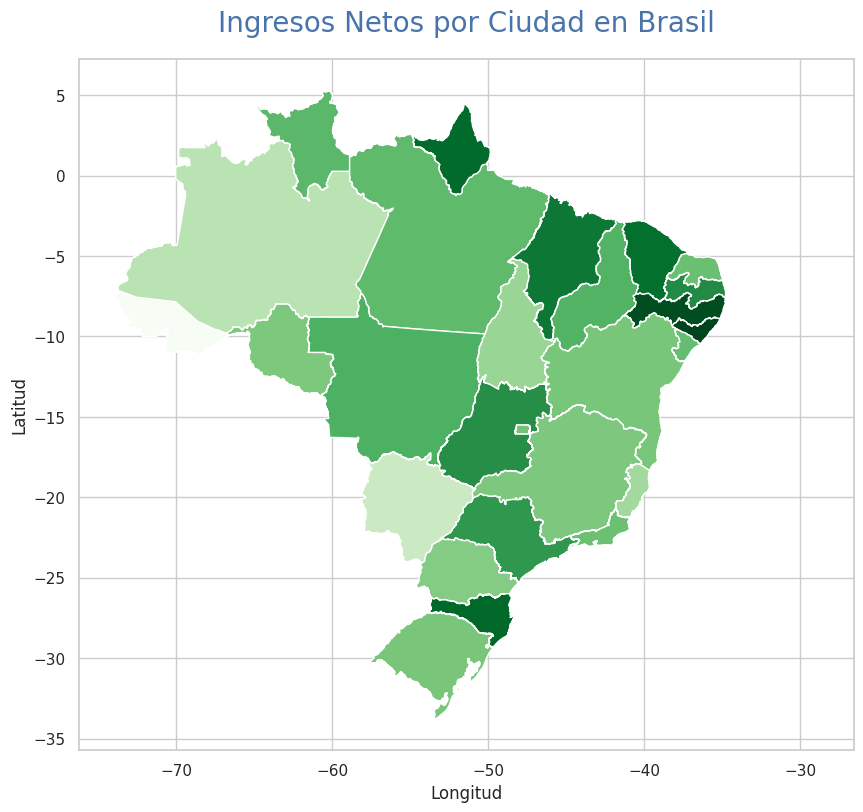

In [102]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(10, 10))

# Control del título y los ejes
ax.set_title('Ingresos Netos por Ciudad en Brasil',
             pad=20,
             fontdict={'fontsize': 20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar el mapa finalizado
br_uf_d.plot(column='ingreso_neto', cmap='Greens', ax=ax, zorder=5)

<ipython-input-103-a2e3c98b55e5>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([formatter(tick) for tick in cbar_ticks], fontsize=10)  # Formatea las etiquetas de los ticks de la barra de leyenda


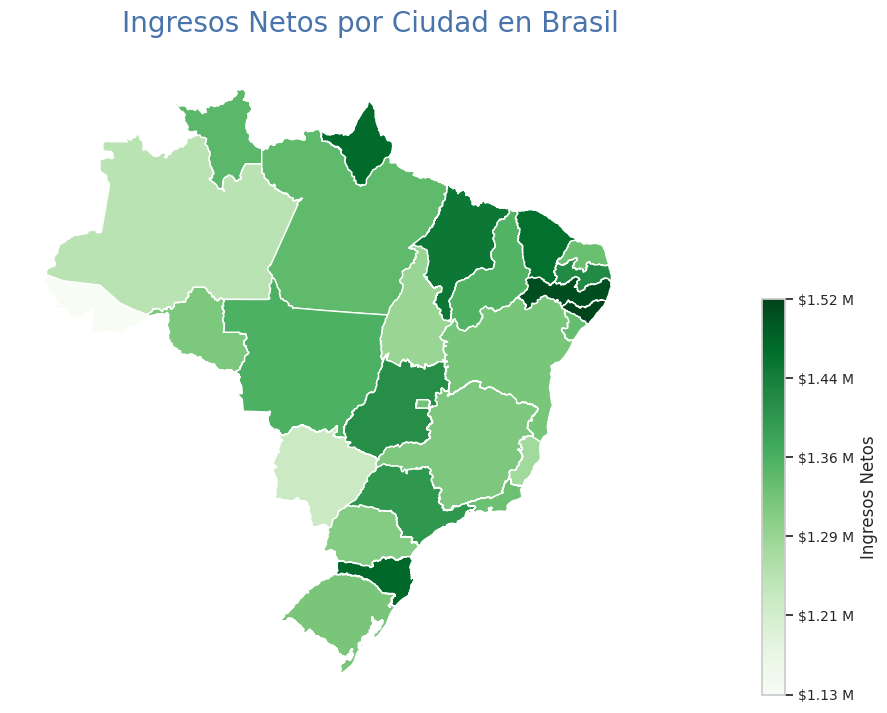

In [103]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title('Ingresos Netos por Ciudad en Brasil',
             pad=20,
             fontdict={'fontsize': 20, 'color': '#4873ab'})

# Ocultar los ejes
ax.axis('off')

# Mostrar el mapa finalizado
br_uf_d.plot(column='ingreso_neto', cmap='Greens', ax=ax, zorder=5)

# Crear una barra de leyenda personalizada
cbar_label = 'Ingresos Netos'

formatter = ticker.FuncFormatter(lambda x, pos: '${:,.2f} M'.format(x / 1000000))
locator = MaxNLocator(nbins=7)
cbar_ticks = np.linspace(br_uf_d['ingreso_neto'].min(), br_uf_d['ingreso_neto'].max(), num=6)  # Define los ticks de la barra de leyenda
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Greens'), ax=ax, fraction=0.03, pad=0.04, aspect=17, format=formatter)  # Ajusta la ubicación y el tamaño de la barra de leyenda
cbar.ax.set_ylabel(cbar_label, rotation=90, fontsize=12)
cbar.ax.set_yticklabels([formatter(tick) for tick in cbar_ticks], fontsize=10)  # Formatea las etiquetas de los ticks de la barra de leyenda

cbar.ax.set_position([cbar.ax.get_position().x0, -0.006, cbar.ax.get_position().width, cbar.ax.get_position().height])

plt.show()